In [ ]:
import torch
from torch import nn
torch.__version__

'2.0.1+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sun Jun 25 08:52:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
!pwd

/content/drive/MyDrive
/content/drive/MyDrive


# **Load data**

In [ ]:
import requests
import zipfile
from pathlib import Path


data_path = Path("food101/")
image_path = data_path / "classify"

if image_path.is_dir():
  print(f"{image_path} already exist...skipping download")
else:
  print(f"{image_path} creating...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)


food101/classify already exist...skipping download


In [ ]:
intel_path ="/content/drive/MyDrive/intel/seg_train"

In [ ]:
import os
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

there are2 directories and 0 images in 'food101/classify'
there are3 directories and 0 images in 'food101/classify/test'
there are0 directories and 25 images in 'food101/classify/test/pizza'
there are0 directories and 19 images in 'food101/classify/test/steak'
there are0 directories and 31 images in 'food101/classify/test/sushi'
there are3 directories and 0 images in 'food101/classify/train'
there are0 directories and 78 images in 'food101/classify/train/pizza'
there are0 directories and 75 images in 'food101/classify/train/steak'
there are0 directories and 72 images in 'food101/classify/train/sushi'


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
print(train_dir, test_dir)

food101/classify/train food101/classify/test


# **Visualize**

random image path: food101/classify/train/sushi/1280119.jpg
 image class: sushi
 image height: 512
 image width: 512


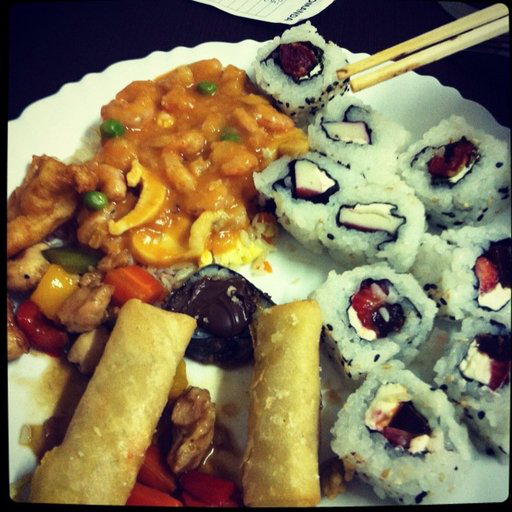

In [ ]:
import random
from PIL import Image

#random.seed(12)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"random image path: {random_image_path}")
print(f" image class: {image_class}")
print(f" image height: {img.height}")
print(f" image width: {img.width}")
img

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread(random_image_path)
# imgplot = plt.imshow(img)
# plt.show()



(-0.5, 511.5, 511.5, -0.5)

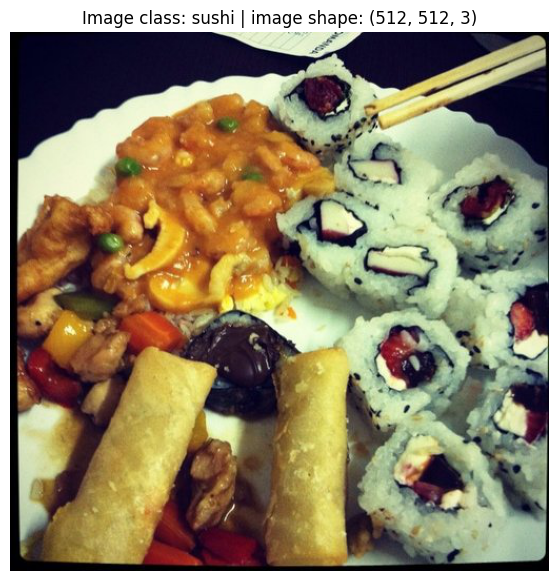

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array )
plt.title(f"Image class: {image_class} | image shape: {img_as_array.shape}")
plt.axis(False)

# **Transform**
Tensor -> Dataset -> dataloader

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape
#data_transform(img).dtype

torch.Size([3, 64, 64])

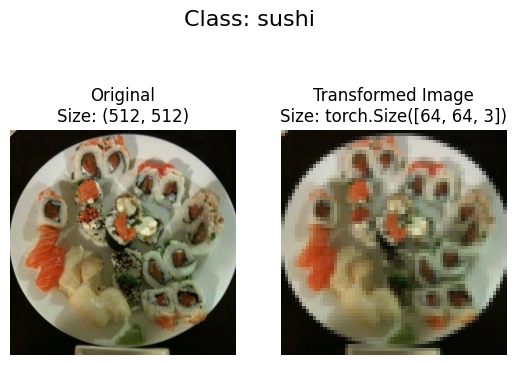

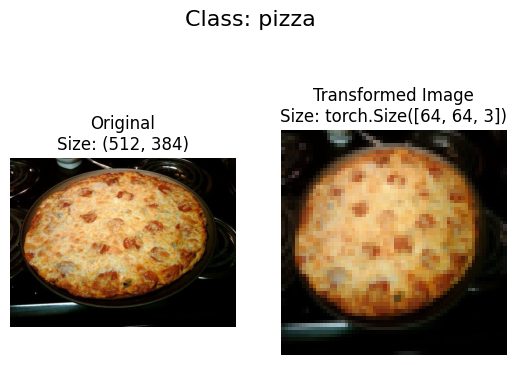

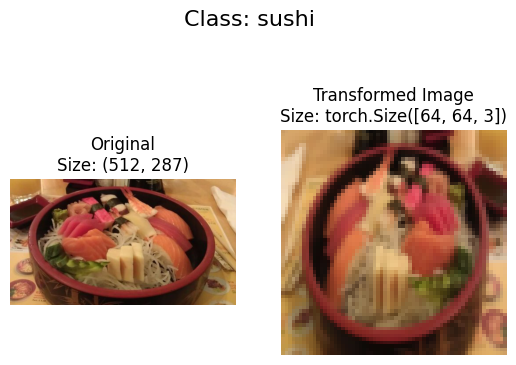

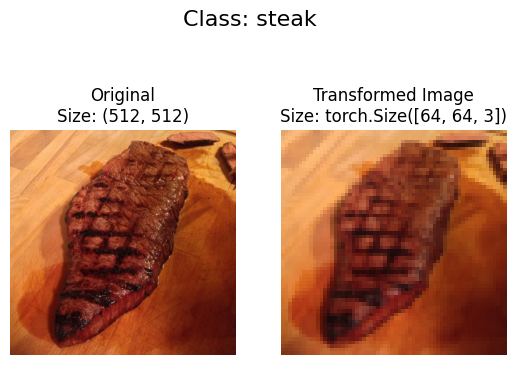

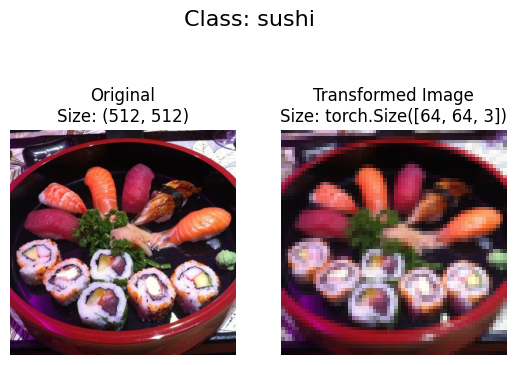

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed = 12):

  if seed:
    random.seed(12)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)


      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed Image\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths= image_path_list,
                        transform= data_transform,
                        n=5,
                        seed=12)


# **ImageFolder**

In [ ]:
from torchvision import datasets
train_data= datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data= datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: food101/classify/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: food101/classify/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
type(train_data[0][0])

torch.Tensor

In [ ]:
os.cpu_count()

2

# **DataLoader**

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True
                              )

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False
                              )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f15466caf20>,
 <torch.utils.data.dataloader.DataLoader at 0x7f15466c8a90>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])
label shape: torch.Size([32])


In [ ]:
label

tensor([2, 1, 0, 0, 2, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 0,
        2, 2, 2, 0, 0, 1, 1, 2])

# **Custom dataset loader**

In [ ]:
import os
import pathlib

from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [ ]:
train_intel = "/content/drive/MyDrive/intel/seg_train/seg_train"

In [ ]:
target_directory = train_intel
print(f"Target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: /content/drive/MyDrive/intel/seg_train/seg_train


['buildings',
 'forest',
 'glacier',
 'mountain',
 'sea',
 'street',
 'y.pickle',
 'y_test.pickle']

In [ ]:

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any class in {directory} ")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}


  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 {'buildings': 0,
  'forest': 1,
  'glacier': 2,
  'mountain': 3,
  'sea': 4,
  'street': 5})

# **__len__, __getitem__**

In [ ]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):

    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    self.transform = transform

    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:

    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:

    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:

    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
test_intel = "/content/drive/MyDrive/intel/seg_test/seg_test"

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_intel,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_intel,
                                      transform=test_transforms)

In [ ]:
class_names = train_data_custom.classes

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f3190c8ed10>,
 <__main__.ImageFolderCustom at 0x7f326d4a38e0>)

In [ ]:
len(train_data_custom)

13687

In [ ]:
train_data_custom.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
train_data_custom.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
img, label = train_data_custom[0]

In [ ]:
label

0

In [ ]:
import torch

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
w = torch.tensor([0.1, 0.2, 0.3], requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

y = torch.sum(w * x) + b
loss = y**2

# Perform backpropagation to compute gradients
loss.backward()

# Access the gradients
print(x.grad)  # Gradient of x
print(w.grad)  # Gradient of w
print(b.grad)  # Gradient of b


tensor([0.3800, 0.7600, 1.1400])
tensor([ 3.8000,  7.6000, 11.4000])
tensor(3.8000)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mg_as_array = np.asarray(train_data_custom[100][0].permute(1,2,0))

plt.figure(figsize=(10,7))
plt.imshow(img_as_array )
plt.title(f"Image class: {train_data_custom[100][1]} | image shape: {img_as_array.shape}")
plt.axis(False)

NameError: ignored

<Figure size 1000x700 with 0 Axes>

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"n shouldn't be more than 10")

  if seed:
    random.seed(seed)

  random_sample_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

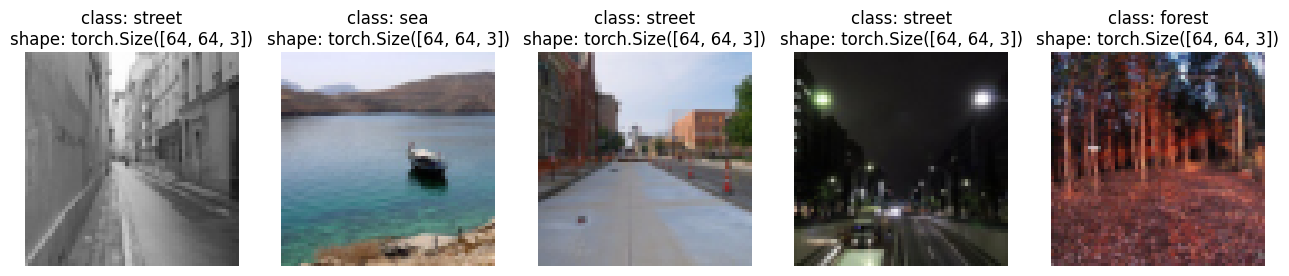

In [ ]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=20)

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

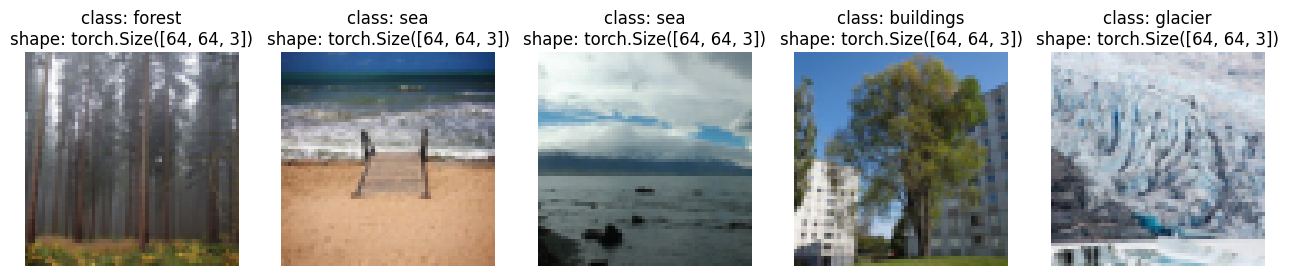

In [ ]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
type(train_data_custom)

__main__.ImageFolderCustom

In [ ]:
random.sample(range(len(train_data_custom)), k=20)

[9387,
 2775,
 442,
 6742,
 6664,
 1228,
 1691,
 2049,
 5228,
 7772,
 9513,
 7362,
 6749,
 3418,
 3273,
 5192,
 10246,
 11162,
 5497,
 5386]

# **Custom -> DataLoader**

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)
test_dataloader_custom = DataLoader( dataset = test_data_custom,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f15267fdde0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f15267fc670>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
label_custom

tensor([3, 2, 0, 4, 0, 3, 2, 3, 1, 2, 1, 4, 4, 4, 1, 2, 1, 5, 1, 2, 2, 4, 0, 3,
        0, 5, 4, 3, 5, 5, 3, 4])

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
                                     transforms.Resize(size=(224, 224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()
])

test_transform = transforms.Compose([
                                     transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()
])

In [ ]:
intel_path = Path("/content/drive/MyDrive/intel/seg_train")

In [ ]:
type(intel_path)

pathlib.PosixPath

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('food101/classify/test/pizza/540882.jpg'),
 PosixPath('food101/classify/test/pizza/714866.jpg'),
 PosixPath('food101/classify/test/pizza/194643.jpg'),
 PosixPath('food101/classify/test/pizza/2236338.jpg'),
 PosixPath('food101/classify/test/pizza/3092704.jpg'),
 PosixPath('food101/classify/test/pizza/309892.jpg'),
 PosixPath('food101/classify/test/pizza/1925494.jpg'),
 PosixPath('food101/classify/test/pizza/2124579.jpg'),
 PosixPath('food101/classify/test/pizza/2019408.jpg'),
 PosixPath('food101/classify/test/pizza/344397.jpg')]

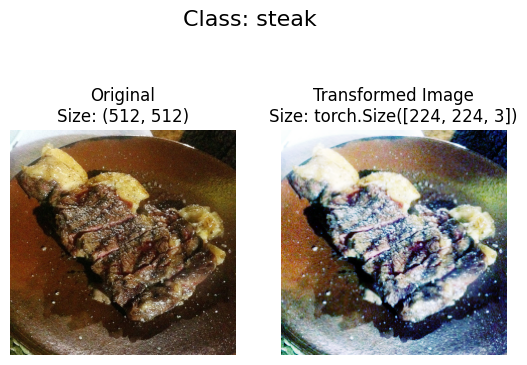

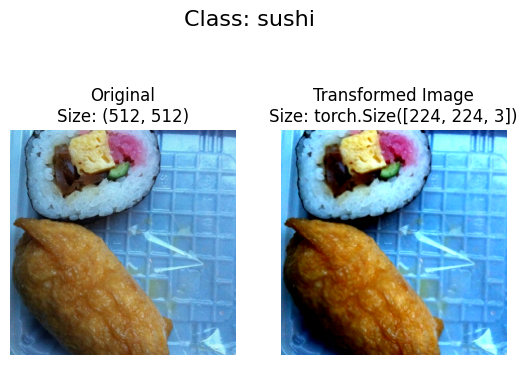

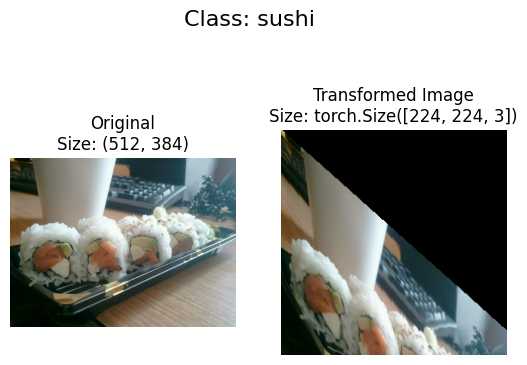

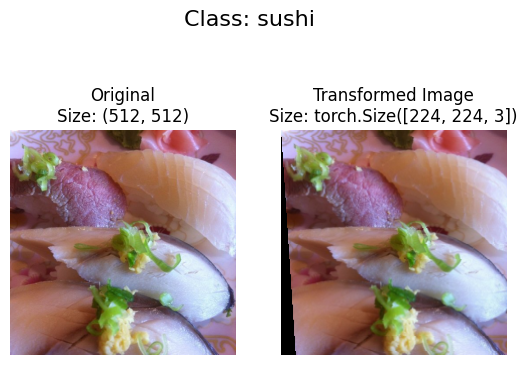

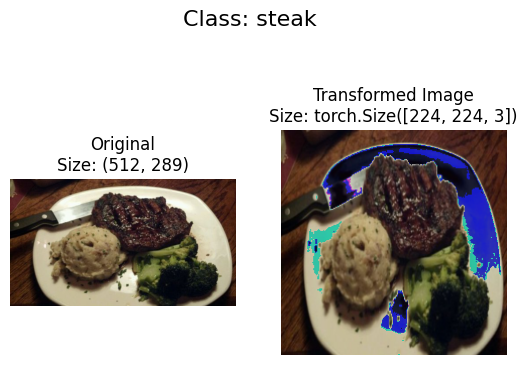

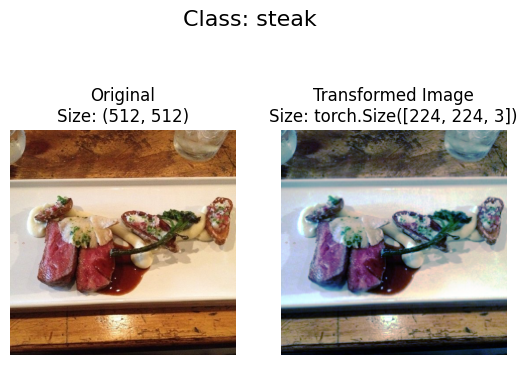

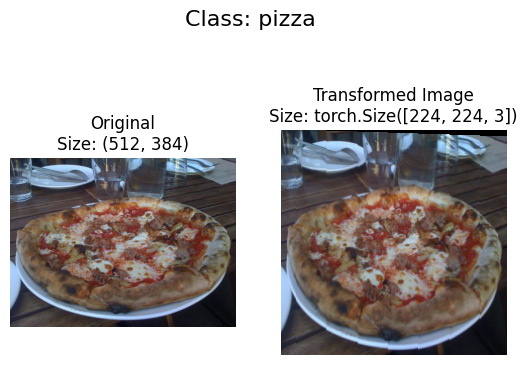

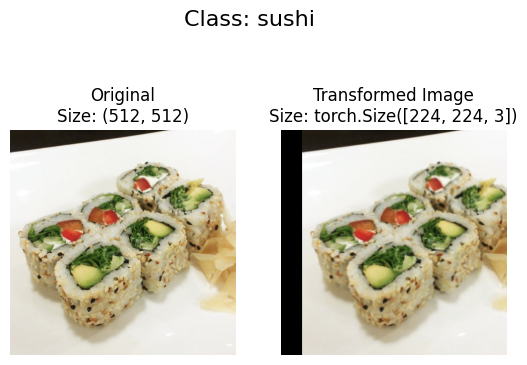

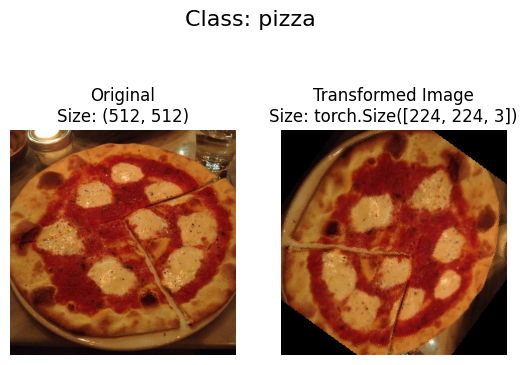

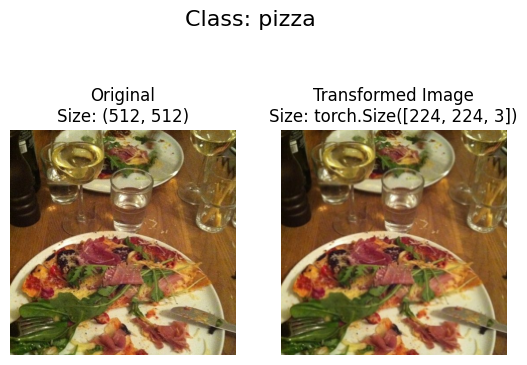

In [ ]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 10,
    seed=None
)

In [ ]:
image_path_list = list(intel_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19608.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19513.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19455.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19456.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19584.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/1954.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19638.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19623.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/1959.jpg'),
 PosixPath('/content/drive/MyDrive/intel/seg_train/seg_train/buildings/19416.jpg')]

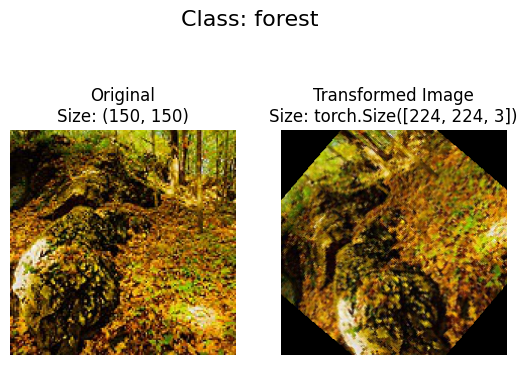

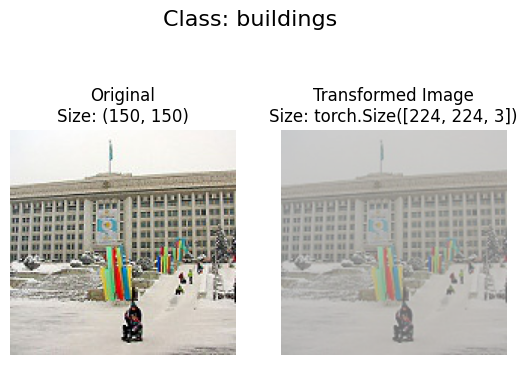

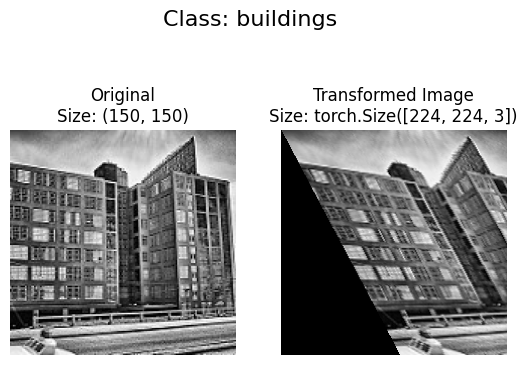

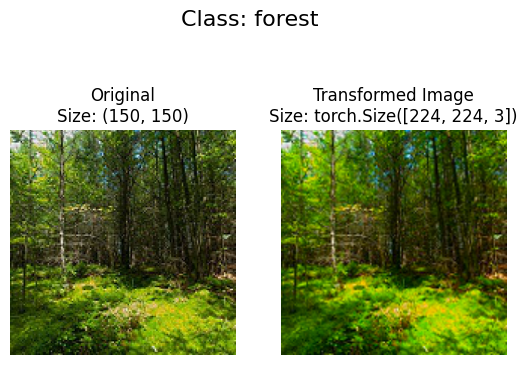

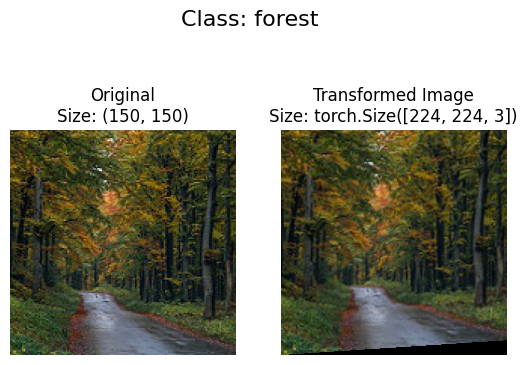

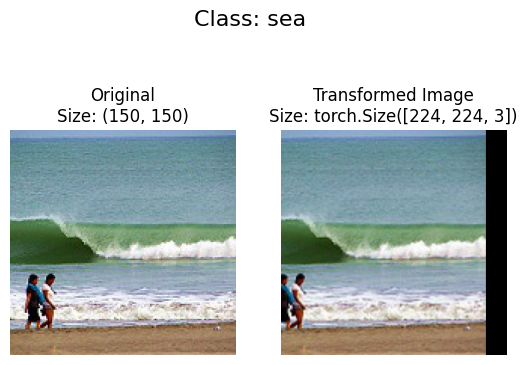

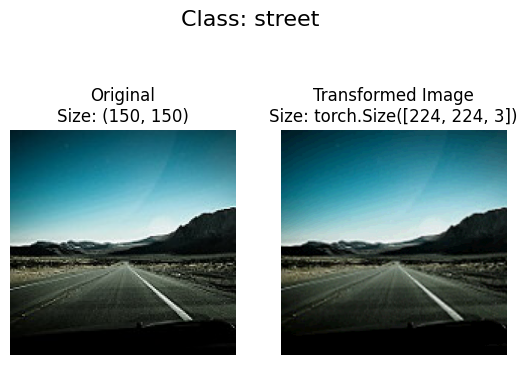

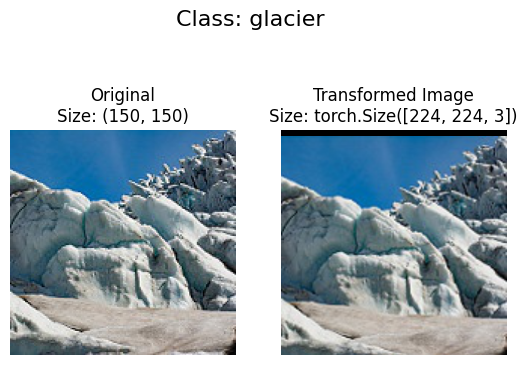

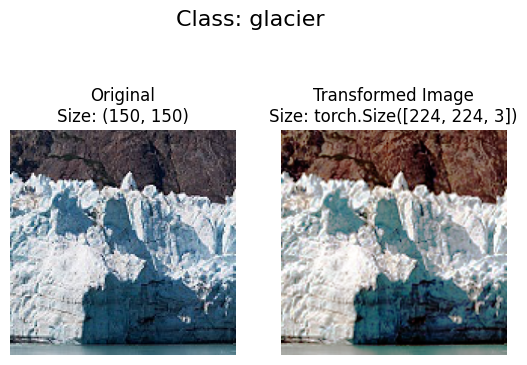

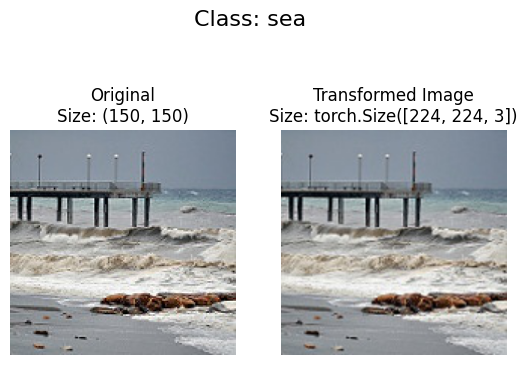

In [ ]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 10,
    seed=None
)

# ***TinyVGG W/O data aug ***

In [ ]:
simple_transform = transforms.Compose([
                                     transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()
])

In [ ]:
test_intel = "/content/drive/MyDrive/intel/seg_test/seg_test"

In [ ]:
from torchvision import datasets
train_simple_data = datasets.ImageFolder(root=train_intel,
                                         transform=simple_transform)
test_simple_data = datasets.ImageFolder(root=test_intel,
                                         transform=simple_transform)

In [ ]:
train_dataloader_simple = DataLoader(dataset=train_simple_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True
                              )

test_dataloader_simple = DataLoader(dataset=test_simple_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False
                              )


In [ ]:
class TinyVGG(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)


    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)


    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [ ]:
len(class_names)

6

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=6, bias=True)
  )
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[ 2.8875e-02,  4.4096e-03,  3.0624e-02,  6.0057e-04, -1.7742e-03,
          4.2934e-03],
        [ 2.5749e-02,  4.2220e-03,  3.2452e-02,  3.1323e-03, -1.6388e-03,
          2.7174e-03],
        [ 3.0392e-02,  2.3509e-03,  3.0373e-02, -3.2839e-04, -1.0524e-05,
          5.8844e-03],
        [ 3.0809e-02,  2.8398e-03,  3.0817e-02, -8.2756e-04,  2.0618e-04,
          4.6010e-03],
        [ 3.1281e-02,  1.8526e-03,  3.3078e-02,  2.5039e-03, -1.5481e-03,
          3.9019e-03],
        [ 3.0400e-02, -3.1302e-03,  3.3484e-02,  4.1684e-04,  2.4043e-03,
          7.3727e-03],
        [ 3.0462e-02,  1.9098e-03,  3.2009e-02, -5.1151e-04, -9.8192e-04,
          4.2535e-03],
        [ 2.9981e-02,  2.2479e-03,  3.1846e-02, -1.8980e-03,  3.6716e-04,
          3.7770e-03],
        [ 2.8229e-02,  4.9456e-03,  3.0229e-02, -1.7531e-05,  4.6061e-04,
          3.6828e-03],
        [ 3.0492e-02,  1.4993e-03,  2.9553e-02,  1.6190e-03,  3.8176e-03,
          4.1230e-03],
        [ 3.0851e-02,  3.0627e

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[32,3,64,64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 6]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

# **Create train and test function**

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device= device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss/ len(dataloader)
  train_acc = train_acc/ len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device= device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    X, y = X.to(device), y.to(device)
    test_pred_logits= model(X)

    loss = loss_fn(test_pred_logits, y)
    test_loss += loss.item()

    test_pred_labels = test_pred_logits.argmax(dim=1)
    test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  test_loss = test_loss/ len(dataloader)
  test_acc = test_acc/ len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device
          ):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader= train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = train_step(model = model,
                                       dataloader= test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results
